# Natural Language Processing for Disaster Tweets 

Here we will use the data from the Kaggle Competition for processing disaster tweets. The data needs to be import and cleaned and then we will do EDA by making a word cloud and seeing what other comparisions we can make. We will need to clean the data set and then we will build a Random Forest Classifier that will allow us to build models. 

In [72]:
#install packages 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from tqdm import tqdm

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
stop_words = stopwords.words('english')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score,f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

#this was helped by https://www.kaggle.com/code/akshinguseinov/nlp-twitter-disaster
#this was helped by https://www.kaggle.com/code/ivanleomk/kaggle-nlp-approach-to-disaster-tweets



from wordcloud import WordCloud

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [73]:
nltk.download('stopwords')
nltk.download('wordnet')
! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [74]:
# read in the data and display the first few rows of information
data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Once we have read the data in, we will take a quick look and see if we need all of that information, if we have any null values, and do a check for distribution.

In [75]:
#let us look at the dataset info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [76]:
# we can remove unneeded columns

data.drop(['id','location'], axis = 1, inplace = True)

data.head()

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [77]:
#we want to see if we have any null values in the reduced dataset information 

data.isnull().sum()

keyword    61
text        0
target      0
dtype: int64

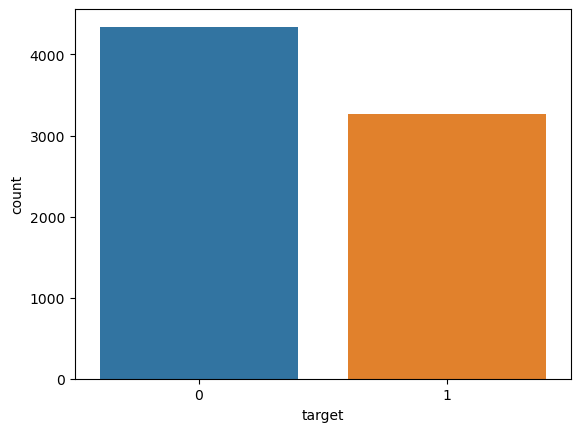

In [133]:
#Can we use the target value to see a qucik distribution

ax = sns.countplot( x = "target", data = data)

In [107]:
#let us find keywords in value counts

key_counts = data['keyword'].value_counts(normalize = True)

key_counts

fatalities               0.005959
deluge                   0.005561
armageddon               0.005561
sinking                  0.005429
damage                   0.005429
                           ...   
forest%20fire            0.002516
epicentre                0.001589
threat                   0.001457
inundation               0.001324
radiation%20emergency    0.001192
Name: keyword, Length: 221, dtype: float64

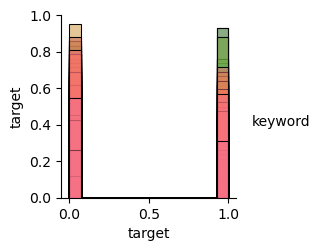

In [113]:
#looking to compare words in a different way

sns.pairplot(data, hue = "keyword", diag_kind = "hist")

In [117]:
#We should clean the text: remove URLs, html tags, punctuation, stopwords, & emoticons

sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) 
    text = re.sub(r"http\S+", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) 
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'')
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text)
    
    
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis

    
    return text

In [118]:
# Now that we have removed the unnecessary, we can see our data better

data['c_text'] = data['text'].apply(lambda x: clean_text(x))

data["c_text"]

0              deed reason earthquake may allah forgive u
1                   forest fire near la ronge sask canada
2       resident asked shelter place notified officer ...
3       , people receive wildfire evacuation order cal...
4       got sent photo ruby alaska smoke wildfire pour...
                              ...                        
7608    two giant crane holding bridge collapse nearby...
7609    aria ahrary thetawniest control wild fire cali...
7610            utc km volcano hawaii http tco zdtoyd ebj
7611    police investigating e bike collided car littl...
7612    latest home razed northern california wildfire...
Name: c_text, Length: 7613, dtype: object

In [121]:
#we need to remove twitter links that have shown to be a problem as well
pattern = r"http://t\.co/\w+|@\w+"
filtered_data = data[data["c_text"].str.contains("tco")]


def remove_links(text):

    return re.sub(pattern, "", text)


filtered_data['text'].apply(remove_links)

31                              Wholesale Markets ablaze 
32          We always try to bring the heavy. #metal #RT 
33      #AFRICANBAZE: Breaking news:Nigeria flag set a...
35      On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
37                      INEC Office in Abia Set Ablaze - 
                              ...                        
7606    Suicide bomber kills 15 in Saudi security site...
7607    #stormchase Violent Record Breaking EF-5 El Re...
7608    Two giant cranes holding a bridge collapse int...
7610          M1.94 [01:04 UTC]?5km S of Volcano Hawaii. 
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 3975, dtype: object

In [134]:
#Let us make a visual with our new cleaned text

def generate_wordcloud_of_data_col(filtered_data, column):
    text_data = filtered_data[column]
    combined_text = ' '.join(text_data)
    wordcloud = WordCloud(width = 300, height = 300, background_color = 'white', min_font_size = 6).generate(combined_text)
    
    plt.figure(figsize = (6, 6), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

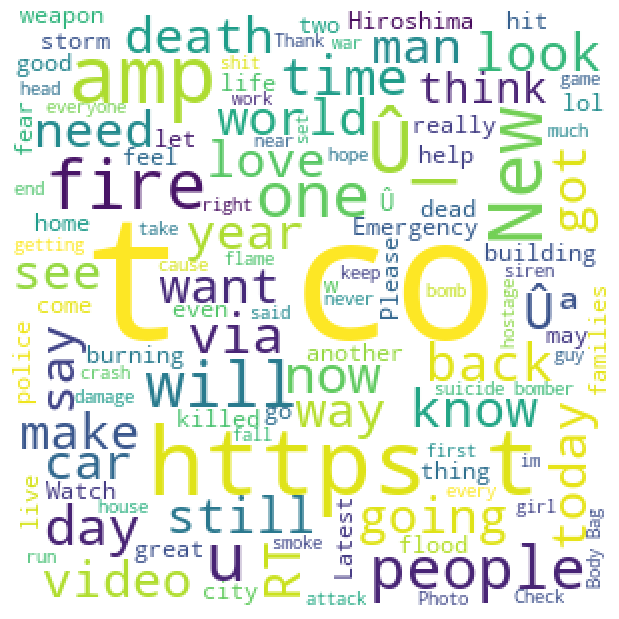

In [135]:
#this word cloud is created from the text prior to removing unnecessary components

generate_wordcloud_of_data_col(data, "text")

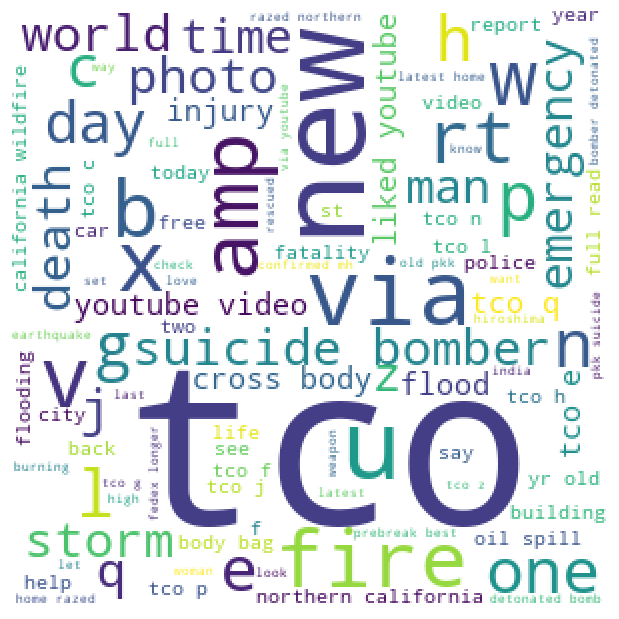

In [136]:
#Now it will be interesting to see the word cloud of the cleaned text

generate_wordcloud_of_data_col(filtered_data, "c_text")

In [126]:
#split training and test data set

X_train, X_test, y_train, y_test = train_test_split(data, data['target'].values, test_size = 0.2, random_state = 123,
                                                   stratify = data['target'].values)

In [127]:
#Let us try a Random Forest Classifier 
def train_on_single_column(col_name):
    t_vectorizer = TfidfVectorizer() 
    t_train_vectors = t_vectorizer.fit_transform(X_train[col_name].values)
    t_test_vectors = t_vectorizer.transform(X_test[col_name].values)
    
    classifier = RandomForestClassifier()
    
    classifier.fit(t_train_vectors,y_train)
    y_predictions = classifier.predict(t_test_vectors)
    print(classification_report(y_test,y_predictions))
    f1 = f1_score(y_test, y_predictions)
    accuracy = accuracy_score(y_test, y_predictions)
    print(f"F1 Score: {f1:.4f}")
    print(f"Total accuracy: {accuracy:.4f}")
    return y_predictions
    
def generate_prediction_ranking(values,predictions):
    cnf_matrix = confusion_matrix(values,predictions)
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in cnf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cnf_matrix, annot=labels, fmt='', cmap='Blues');

In [128]:
columns = ["text", "c_text"]

predictions = []

for column in columns:
    print(f"Single Column Train{column}")
    
    text_predictions = train_on_single_column(column)
    predictions.append(text_predictions)
    
    print("----")

Single Column Traintext
              precision    recall  f1-score   support

           0       0.75      0.92      0.83       869
           1       0.85      0.60      0.70       654

    accuracy                           0.78      1523
   macro avg       0.80      0.76      0.77      1523
weighted avg       0.80      0.78      0.78      1523

F1 Score: 0.7048
Total accuracy: 0.7833
----
Single Column Trainc_text
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       869
           1       0.83      0.65      0.73       654

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523

F1 Score: 0.7312
Total accuracy: 0.7938
----


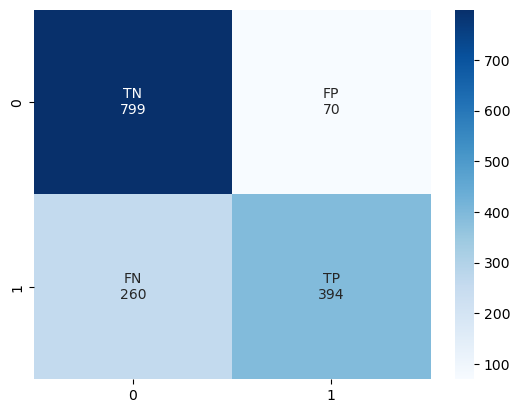

In [129]:
#Now, we can make models of each individually 

generate_prediction_ranking(y_test, predictions[0])

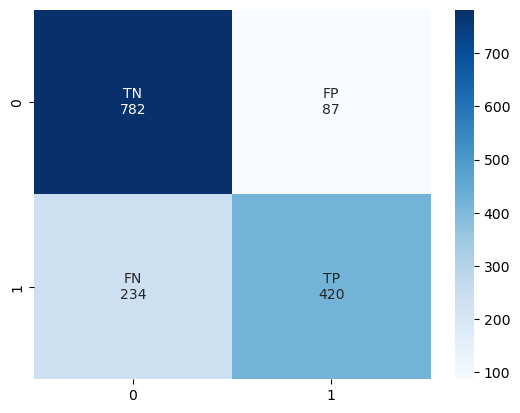

In [106]:
generate_prediction_ranking(y_test, predictions[1])

## Now that we have built a random tree classifier, it can be used to make predictions about what disaster is happening based on the words. You can change this for certain words in certain areas or based upon the user, say if it was weather and people wanted to find live updates to consider, this could be helpful here. I was not able to remove the twitter links that kept coming up in the word cloud. 